## Metasploit Payload Size
#### Or: "How big can my stagers be, really?"

The idea here is to parse through the Metasploit Project's available exploits to determine what the distribution of payload sizes is.

This can help make decisions for stager size optimization - if I have a great idea for a stager (or other exploit payload), but can't make it any smaller than 1k, is it worth it? What if it's 2k? And so on.

As it turns out, payloads over 2kb work with less than 20% of available exploits, and payloads over 1kb only work with about 60% - if you can't make your stager under 2k, you shouldn't expect to be able to use it very often at all.

In [10]:
%matplotlib inline

import os
import re
import sys
import numpy as np
import matplotlib

matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

In [2]:
# Set up a path to the Metasploit project's code.
basepath = os.path.join('/', 'home', 'dnelson', 'projects', 'msf-stats')
rootdir = os.path.join(basepath, 'metasploit-framework', 'modules', 'exploits')
rootdir

'/home/dnelson/projects/msf-stats/metasploit-framework/modules/exploits'

In [3]:
# Iterate through every exploit module, searching for the amount of space that exploit provides to fit a payload in.
all_sizes = []
for folder, subs, files in os.walk(rootdir):
    for filename in files:
        with open(os.path.join(folder, filename), 'r') as sploit:
            #print("parsing " + filename + "...")
            text = sploit.read()
            # remove all whitespace
            text = ''.join(text.split())
            space = re.search("\'Space\'=>(\d+)\,", text)
            # Note that if no payload size limit is specified, we simply ignore that module
            if space:
                all_sizes.append(int(space.group(1)))

print("Modules processed: " + str(len(all_sizes)))

Modules processed: 950


In [4]:
sorted_sizes = np.sort(all_sizes)
cumulative = np.cumsum(sorted_sizes)

print(sorted_sizes)

# looks to me like we should exclude that last one, since it's waaaaaaay larger than the rest
sorted_sizes = sorted_sizes[:-1]

[     100      127      128      128      130      153      160      164
      175      200      200      200      200      200      210      212
      213      220      227      228      232      232      236      250
      250      250      250      250      250      253      255      255
      256      256      256      256      256      260      284      296
      300      300      300      300      300      300      310      336
      336      340      344      344      344      350      370      370
      373      375      380      384      390      392      400      400
      400      400      400      400      400      400      400      400
      400      400      400      400      400      400      400      400
      400      400      400      400      400      400      400      400
      400      400      400      410      417      424      424      434
      440      444      450      450      450      450      450      450
      460      466      472      475      476      

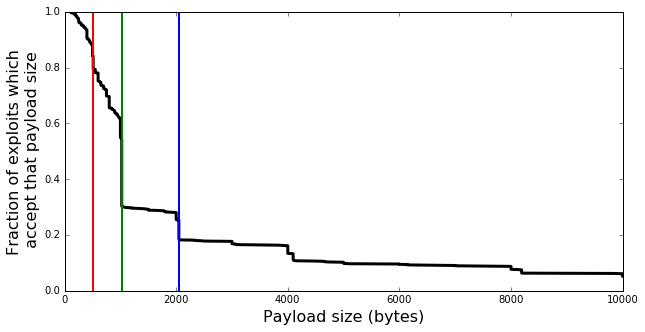

In [20]:
# Plot our sorted sizes against a fraction, 0 to 1, of all exploits.
plt.figure(figsize = (10,5))
plt.plot(sorted_sizes, np.linspace(1,0,len(sorted_sizes)), linewidth=3, color='black')
plt.xlim((0,10000))

plt.xlabel("Payload size (bytes)", size=16)
plt.ylabel("Fraction of exploits which\n accept that payload size", size=16)

# Plot some vertical lines for emphasis; a red line at 512 bytes, green at 1024, and blue at 2048.
plt.axvline(512, color='red', linewidth=2)
plt.axvline(1024, color='green', linewidth=2)
plt.axvline(2048, color='blue', linewidth=2)
plt.show()

We'll start with displaying payload size against the fraction of exploits which will work (or not work) for that size. It looks like any payload over 2048 bytes will only work with about 20% of exploits - a little less, in fact! If any of your stagers are just barely above 1024 bytes, it's well worth the effort to trim those last few bytes. Almost a quarter of exploits available in Metasploit have a payload size cutoff at 1024 bytes.

This chart can also be read as a probability: if I want to send a 1000 byte payload, and I pick an exploit at random (or, I find a vulnerable host at random), I have about a 60% chance that the exploit I end up with will be able to accomodate that payload. If my payload is 500 bytes, that probability becomes more than 90%.

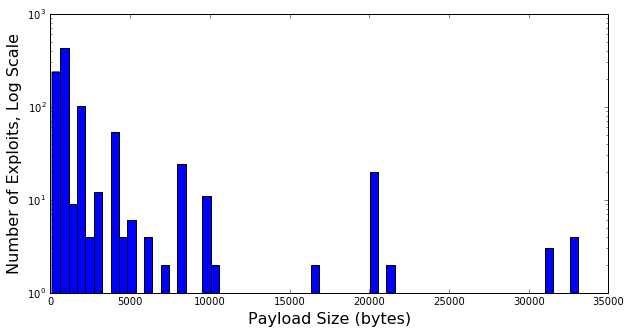

In [22]:
plt.figure(figsize = (10,5))
plt.hist(sorted_sizes, 500)

plt.xlim((0,35000))
plt.yscale('log')

plt.xlabel("Payload Size (bytes)", size=16)
plt.ylabel("Number of Exploits, Log Scale", size=16)
plt.show()

The humble histogram finishes out our exploration today - note that it's on a log scale. This is significantly less useful than the above charts, since payload size is a cumulative number (i.e. smaller payloads still work in exploits with more than enough space for them), but this view is interesting in that it shows us where there are large clusters of exploits accepting a certain payload size.

But, what about platforms? Are our results being influenced by the category of the exploit? (Windows and Linux vs. Android and iOS, etc.)

In [8]:
sploitsByCategory = {}
for folder, subs, files in os.walk(rootdir):
    for filename in files:
        with open(os.path.join(folder, filename), 'r') as sploit:
            #print("parsing " + filename + "...")
            text = sploit.read()
            # remove all whitespace
            text = ''.join(text.split())
            space = re.search("\'Space\'=>(\d+)\,", text)
            # Note that if no payload size limit is specified, we simply ignore that module
            if space:
                # get the first folder in the exploits directory by
                # 1. Stripping off the rootdir using [len(rootdir):]
                # 2. Splitting on the folder separator (not platform-independent)
                # 3. Taking the first one (the zeroth one is '' since there's always a leading /)
                sploitType = folder[len(rootdir):].split('/')[1]
                try:
                    sploitsByCategory[sploitType].append(int(space.group(1)))
                except KeyError:
                    sploitsByCategory[sploitType] = []
                    sploitsByCategory[sploitType].append(int(space.group(1)))

# Yeah, that's right, a nested list comprehension. To print.
[str(sploits) + ": " + ",".join([str(num) for num in sploitsByCategory[sploits]]) for sploits in sploitsByCategory]

['aix: 4104',
 'freebsd: 175,1024,128,1024,1024',
 'netware: 400,2020',
 'osx: 8192,512,1000,3841,400,300,1024,1024,300,1024,1024',
 'hpux: 200',
 'unix: 512,1024,1024,1024,1024,65535,1024,1024,262144,262144,6144,1024,1024,4000,1024,4000,1024,4000,32768,32768,512,127,1024,1024,4000,4000,10000,512,4000,8190,200,4096,512,8000,1024,1024,512,1024,1024,262144,1024,8000,8000,8190,16384,1024,8190,1024,512,512,512,4000,512,1024,4000,1024,512,512,1024,16384,262144,1024,1024,8192,1024,200,2000,2000',
 'dialup: 3000',
 'multi: 10000000,390,500,1024,1024,1024,4096,512,300,1024,20480,2048,344,1024,60000,512,344,466,1024,10000,2048,512,21244,10000,475,10000,10000,31337,1024,8000,31337,6144,2000,8190,4000,262144,4000,2000,1024,8190,1024,4000,4000,1024,8190,10000,262144,4000,31337,8192,1024,4096,10000,4000,5000,262144,2000,262144,4000,2048,8000,20480,1024,1024,2048,20480,20480,20480,20480,512,20480,20480,20480,20480,20480,20480,20480,20480,1024,400,4000,20480,1024,20480,20480,232,232,2000,1675,256,102

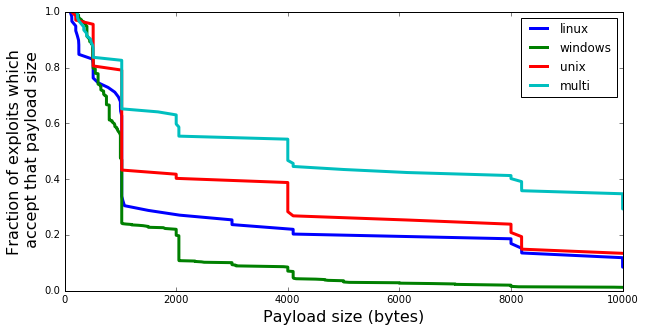

In [9]:
sortedSploits = {}
platforms = ['linux', 'windows', 'unix', 'multi']
for platform in platforms:
    sortedSploits[platform] = np.sort(sploitsByCategory[platform])

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.figure(figsize = (10,5))
for i, platform in enumerate(platforms):
    plt.plot(sortedSploits[platform], np.linspace(1,0,len(sortedSploits[platform])), linewidth=3, color=colors[i])

plt.xlim((0,10000))

plt.xlabel("Payload size (bytes)", size=16)
plt.ylabel("Fraction of exploits which\n accept that payload size", size=16)

plt.legend([platform for platform in platforms])

plt.show()

Interesting! So, it appears that if you've got a large payload you want to use, your best bet is to find a multi exploit to use it with, followed by unix, then linux, then Windows. For whatever reason, Windows does a better job than the rest at preventing the injection of large payloads.

Take note - if you're designing a stager that'll end up on the larger side, making it Windows-specific is the worst decision you can make - if it's not under 1024 bytes, the best case scenario is that it's useful on about 20% of hosts. (although once you get it under 1024 bytes, the platforms are essentially all the same)